# Entropic Estimation of Optimal Transport maps

Let $P$ be a source distribution and $Q$ be a target distribution such that $(T_0)_\sharp P = Q$, with $T_0$ being the optimal transport map between the two measures. 

This notebook demonstrates how to "learn" the entropic map on the basis of samples $X_1,\ldots,X_n \sim P$ and $Y_1,\ldots,Y_n \sim Q$ as demonstrated in {cite}`pooladian:21`. To do so, we first use the Sinkhorn solver provided in OTT, which returns optimal (entropic) dual potentials $(f_\varepsilon,g_\varepsilon)$. The first paper defined the "Entropic map" as

$$ T_\varepsilon(x) = x - \nabla f_\varepsilon(x) = \mathbb{E}_{\pi_\varepsilon}[Y | X = x]\,. $$

This simply amounts to a barycentric projection of the entropic plan $\pi_\varepsilon$, conditional on the input $x$ that we want to push-forward. 


We will provide a complete tutorial of how to use this estimator using OTT, taking advantage of {class}`~ott.problems.linear.potentials`. 

In [2]:
#%pip install ott-jax

from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

from ott.tools.gaussian_mixture import gaussian

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import time

from scipy import linalg
from scipy.linalg import sqrtm, inv, det
from math import *

import statsmodels.api as sm


### Example 1: Learning Gaussian to Gaussian transport maps

This first example exploits the closed-form solutions available for the Gaussian-to-Gaussian optimal transport problem (focusing on 2D distributions for ease of visualization). We begin by first drawing samples from two Gaussians, $P = \mathcal{N}(0,I)$ and $Q = \mathcal{N}(\mu,\Sigma)$ for some $\mu \in \mathbb{R}^d$ and $\Sigma \succ 0$.

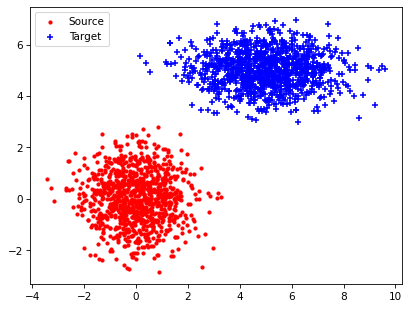

In [3]:
rng = jax.random.PRNGKey(0)
rng, *rngs = jax.random.split(rng, 5)

#problem parameters
dim = 2
n = 1024

# data parameters
Sigma1 = jnp.eye(dim)
Sigma2 = jnp.array([[2,0],[0,0.5]])
mu1 = jnp.zeros((dim))
mu2 = jnp.ones((dim))*5

#generate gaussians and samples
g1 = gaussian.Gaussian.from_mean_and_cov(mu1,Sigma1)
g2 = gaussian.Gaussian.from_mean_and_cov(mu2,Sigma2)
x = g1.sample(rngs[0],n)
y = g2.sample(rngs[0],n)

#plotting [make unified plot!]
fig = plt.figure(dpi=75)
plt.scatter(x[:,0],x[:,1],c='r',marker='.',label='Source')
plt.scatter(y[:,0],y[:,1],c='b',marker='+',label='Target')
plt.legend()

plt.show()

In [4]:
def entropic_potentials(x,y,eps=None):
    geom = pointcloud.PointCloud(x, y, epsilon = eps)
    ot_prob = linear_problem.LinearProblem(geom)
    solver = sinkhorn.Sinkhorn()
    ot_solved = solver(ot_prob)
    return ot_solved.to_dual_potentials()

def entropic_map(x_new, dual_potentials):
    return dual_potentials.transport(x_new)

The aforementioned samples will be the basis of our estimator. From these samples, for a fixed regularization parameter $\varepsilon > 0$, we obtain $(\hat{f}_{n,\varepsilon},\hat{g}_{n,\varepsilon})$, and OTT will also output their gradient defined on all of $\mathbb{R}^d$. Beyond a visual comparison, in order to assess the performance of our estimator empirically, it is necessary to be able to compare to the optimal transport map (using mean-squared error as our criterion). 

It is known that for general Gaussian measures $P = \mathcal{N}(a,A)$ and $Q = \mathcal{N}(b,B)$, the true optimal transport map is known to be

$$ T_0(x) = A^{-1/2}(A^{1/2}BA^{1/2})^{1/2}A^{-1/2}(x-a) + b\,. $$

Thus, determining whether or not our estimator is close amounts to Monte Carlo integration with enough samples i.e.
$$ \| \hat{T}_{\varepsilon,n} - T_0\|^2_{L^2(P)} \simeq \frac{1}{N}\sum_{i=1}^N \| \hat{T}_{\varepsilon,n}(X_i) - T_0(X_i)\|^2_2\,, $$
where $X_i \sim P = \mathcal{N}(0,I)$.


To estimate the map using OTT, we call `entpots = EntropicPotentials()`, which takes in as inputs the potentials from the `sinkhorn()` method. To transport, we use `entpots.transport()` applied to new points that we want to pushforward according to our estimator.

Mean-Squared Error 0.14604005


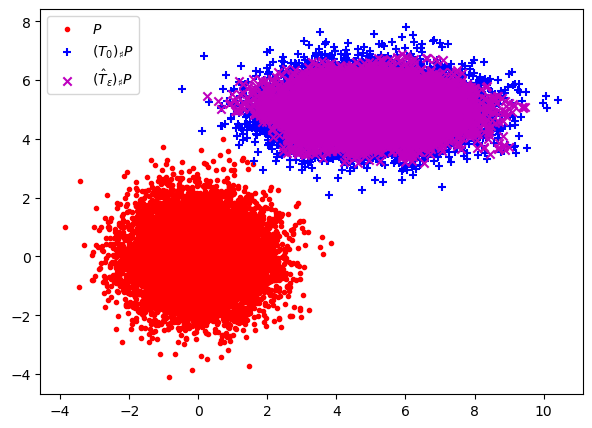

In [8]:
n_new = 10000

#newly sampled points from source distribution
x_new = g1.sample(rngs[2],n_new)

#optimal transportation of new samples
y_new = g1.transport(g2,x_new)

gaussian_entpots = entropic_potentials(x,y, 0.5)
entmap = entropic_map(x_new,gaussian_entpots)

print('Mean-Squared Error', np.mean(np.linalg.norm(entmap - y_new,axis=1)) )

fig = plt.figure(figsize=(7,5))
plt.scatter(x_new[:,0],x_new[:,1],c='r',marker='.',label=r'$P$')
plt.scatter(y_new[:,0],y_new[:,1],c='b',marker='+',label=r'$(T_0)_\sharp P$')
plt.scatter(entmap[:,0],entmap[:,1],c='m',marker='x',label=r'$(\hat{T}_\varepsilon)_\sharp P$')
plt.legend()
plt.show()

### Example 2: Coordinate-wise transport maps

A second example is the case of coordinate-wise transport maps, where the underlying map is $T_0:\mathbb{R} \to \mathbb{R}$, and abusing notation, we write

$$ T_0(x) = (T_0(x[1]),\ldots,T_0(x[d])), $$

for $x \in \mathbb{R}^d$.

A simple example is to consider the coordinate-wise exponential map, where the source distribution is uniform on $[-1,1]^d$, and the target density is then defined as  $Q = (T_0)_\sharp P$. We repeat the same experiment as above.

Mean-Squared Error 0.1725617


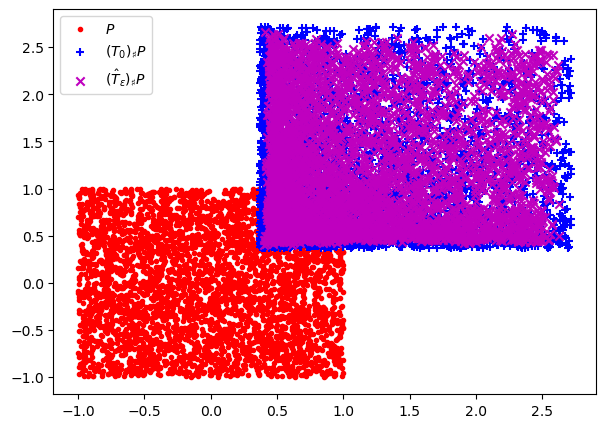

In [12]:
rng = jax.random.PRNGKey(0)

#problem parameters
dim = 5
n = 4096

rng, *rngs = jax.random.split(rng, 5)
x = jax.random.uniform(rngs[0], shape=(n,dim))*2 - 1 ###uniform on [-1,1]^dim
x_ = jax.random.uniform(rngs[1], shape=(n,dim))*2 - 1 
y = jnp.exp(x_)

n_new = 10000
#newly sampled points from source distribution
x_new = jax.random.uniform(rngs[2], shape=(n,dim))*2 - 1 

#closed-form transport map on the newly sampled points
y_new = jnp.exp(x_new)

coord_entpots = entropic_potentials(x,y,0.075)
coord_entmap = entropic_map(x_new,coord_entpots)

print('Mean-Squared Error', np.mean(np.linalg.norm(coord_entmap - y_new,axis=1)) )

fig = plt.figure(figsize=(7,5))
plt.scatter(x_new[:,0],x_new[:,1],c='r',marker='.',label=r'$P$')
plt.scatter(y_new[:,0],y_new[:,1],c='b',marker='+',label=r'$(T_0)_\sharp P$')
plt.scatter(coord_entmap[:,0],coord_entmap[:,1],c='m',marker='x',label=r'$(\hat{T}_\varepsilon)_\sharp P$')
plt.legend()
plt.show()

Note that in both the Gaussian-to-Gaussian example, and the coordinate-wise transport map, the resulting pushforwards $Q_\varepsilon$ are significantly more concentrated than the target measure $Q$. This is because the choice of $\varepsilon$ was not properly chosen, and is crucial to the performance of the estimator. We illustrate this in the following cells.

### Estimation as a function of $\varepsilon$

Here we plot convergence of the estimator as a function of the regularization parameter $\varepsilon$ for a fixed number of samples $n$. What is the natural behavior? By Young's inequality $|a+b|^2 \leq 2a^2 + 2b^2$, we have that

$$ \|\hat{T}_{(\varepsilon , n)} - T_0\|^2_{L^2(P)} \lesssim \|\hat{T}_{(\varepsilon , n)} - T_\varepsilon \|^2_{L^2(P)} + \|T_0 - T_\varepsilon \|^2_{L^2(P)}\,.$$
 
The authors of [Pooladian and Niles-Weed (2021)](https://arxiv.org/abs/2109.12004) show that for fixed $n$, the first term grows as a function of $\varepsilon$, whereas the second term decreases in $\varepsilon$. Thus, we expect a natural "approximation error" vs "statistical error" tradeoff, which is illustrated in the next cell --- we see that there is an optimal choice for the regularization parameter that best estimates the optimal transport map, given that we only have finitely many samples.

In [55]:
rng = jax.random.PRNGKey(1)


dim = 5
lbds = 10 ** np.arange(-2.0, 0.0,step=0.1)
numtrials = 5
mse = np.zeros((numtrials,len(lbds)))
rng, *rngs = jax.random.split(rng, numtrials*3*len(lbds))
n = 4096 

for i,eps in enumerate(lbds):
    for k in range(numtrials):
        rng_iter = i+k
        x = jax.random.uniform(rngs[rng_iter], shape=(n,dim))*2 - 1 ###uniform on [-1,1]^dim

        #resampling
        x_ = jax.random.uniform(rngs[rng_iter+len(lbds)], shape=(n,dim))*2 - 1 
        y = jnp.exp(x_)

        # monte-carlo samples
        n_new = 50000
        #newly sampled points from source distribution
        x_new = jax.random.uniform(rngs[rng_iter+len(lbds)], shape=(n_new,dim))*2 - 1 
        #closed-form transport map on the newly sampled points
        y_new = jnp.exp(x_new)

        coord_entpots = entropic_potentials(x,y,eps)
        coord_entmap = entropic_map(x_new,coord_entpots)            

        mse[k,i] = (jnp.linalg.norm( (y_new - coord_entmap),axis=1)**2).mean()

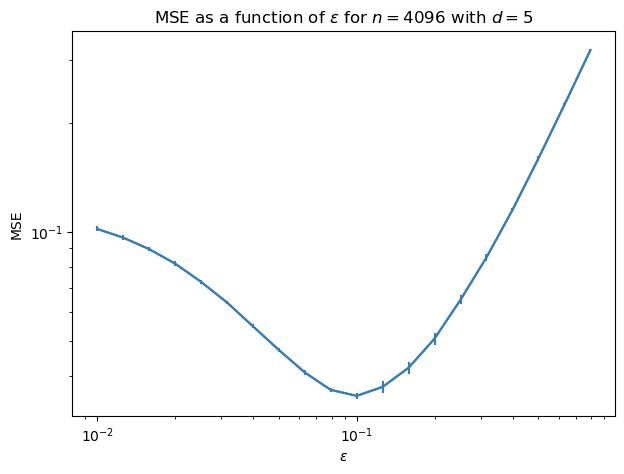

In [56]:
fig = plt.figure(figsize=(7, 5))
x = np.array(lbds)
###compute the means across the trials
y_means = np.mean(mse,axis=0)
###compute the standard deviation across trials
y_stds = np.std(mse,axis=0)
c1='#377eb8'
plt.loglog(x,y_means,label=r'$\hat{T}_\epsilon$',c=c1,linewidth=1.5)
plt.errorbar(x,y_means,yerr=y_stds,c=c1,linewidth=1.5)
plt.ylabel('MSE')
plt.xlabel(r'$\varepsilon$')
plt.title(r'MSE as a function of $\varepsilon$ for $n=${} with $d=${}' .format(n,dim))
plt.show()

# Minimax optimal rate of estimation

The authors of {cite}`pooladian:23` showed that the entropic Brenier map outlined above achieves the minimax rate of estimation when the target measure $Q$ is discrete with $J$ atoms, and $P$ has a density bounded above and below by absolute constants. Their main result reads

$$
\mathbb{E}\| \hat{T}_\varepsilon - T_0\|^2_{L^2(P)} \lesssim \  n^{-1/2}\,,
$$
We will demonstrate this rate on synthetic examples.

Let $P = \text{Unif}([0,1]^d)$ and $Q = \sum_{j=1}^J q_j \delta_{y_j}$, where $q_j = 1/J$ for all $j \in \{1,\ldots,J\}$, and the atoms are designed to be

$$ 
    (y_j)[1] = \frac{j-1/2}{J}, (y_j)[2] = \cdots = (y_j)[d] = 0.5\,.
$$

Under this construnction, one can verify that the optimal transport map $T_0(x)$ is uniquely determined by the first coordinate $x[1]$. The follow cell generates the discrete distribution, as well as the optimal transport map.

In [62]:
def generate_data(J,d):
    data_array = np.ones((J,d))* 0.5
    inc = 0.5 * (1/J)
    base = (1/J)
    for i in range(J):
        data_array[i,0] = i * base + inc
    return data_array

def otmap_J(x,atoms,J):
    ot_x = np.zeros_like(x)
    for i in range(x.shape[0]):
        prev = 0
        curr = 1/J
        found = False
        j = 0
        while not found:
            if prev <= x[i,0] and x[i,0] <= curr:
                found = True
                ot_x[i,:] = atoms[j,:]
            else:
                prev = curr
                curr += 1/J
                j += 1
    return ot_x


In [71]:

#### Fix parameters ####
dim = 10
n_sampling = 10000
J=2
Nz = [50,75,100,150,200,500,750,1000]
numtrials = 10
msez = np.zeros((len(Nz),numtrials))
msez_D = np.zeros((len(Nz),numtrials))
msez_1nn = np.zeros((len(Nz),numtrials))
atoms_J = generate_data(J,dim)

for i, n in enumerate(Nz):
    for t in range(numtrials):

        eps_n = 1/(n**(1/2))
        x_train = np.random.rand(n,dim)
        x_iid = np.random.rand(n,dim)
        y_train = otmap_J(x_iid,atoms_J,J)

        semidiscrete_entpots = entropic_potentials(x_train,y_train,eps_n)

        x_sampling = np.random.rand(n_sampling,dim)
        y_sampling = otmap_J(x_sampling,atoms_J,J)
        
        semidiscrete_entmap = entropic_map(x_sampling,semidiscrete_entpots) 
        
        msez[i,t] =  (np.linalg.norm(semidiscrete_entmap - y_sampling,axis=-1)**2).mean()

slope -0.5286174358984171


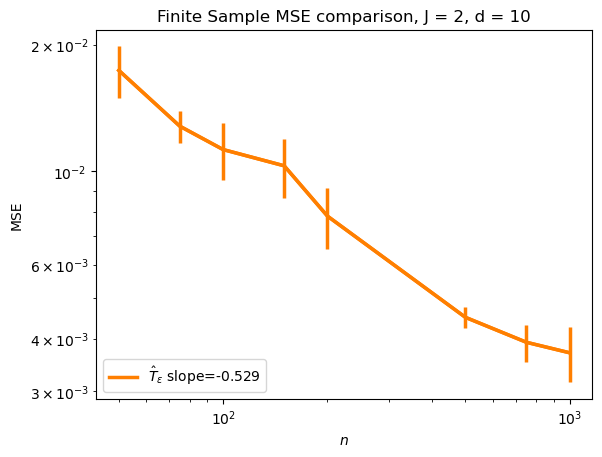

In [72]:
c1='#377eb8'
c2='#ff7f00' 
msez_avg = msez.mean(-1)
msez_std = msez.std(-1)
fig = plt.plot(figsize=(8, 5))
x_axis = np.array(Nz)

x_ = sm.add_constant(np.log(np.array(Nz)))
model_sinkhorn = sm.OLS(np.log(msez_avg), x_).fit()

print('slope',model_sinkhorn.params[1])

plt.loglog(x_axis,msez_avg,label=r'$\hat{T}_{\varepsilon}$ slope=%.3f'%(model_sinkhorn.params[1]),c=c2,linewidth=2.5)
plt.errorbar(x_axis,msez_avg,yerr=msez_std,c=c2,linewidth=2.5)

plt.xlabel('$n$')
plt.ylabel('MSE')
plt.title('Finite Sample MSE comparison, J = {}, d = {}'.format(J,dim))
plt.legend(loc='lower left')
plt.show()


Mean-Squared Error 0.0210924


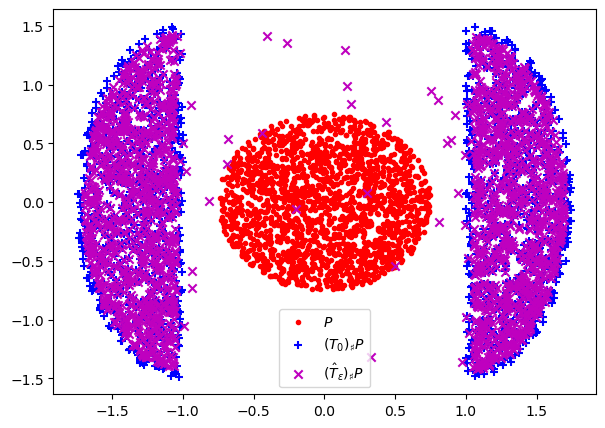

In [54]:
rng = jax.random.PRNGKey(0)

#problem parameters
dim = 2
n = 2000

def OT_splitting(x,r=0):
    y = x
    #for i in range(x.shape[0]):
    #y[:,0] += 2*jnp.sign(x[:,0])
    y += y.at[:,0].set(jnp.sign(x[:,0]))
    return y

rng, *rngs = jax.random.split(rng, 5)
#x_gaussian = jax.random.randn(rngs[0], shape=(n,dim))
#x_ball = jnp.linalg.norm(x_gaussian,axis=0)/dim
#x_ball = jax.random.ball(rngs[0],d=dim,shape=(n,dim))
x = jax.random.ball(rngs[0],d=dim,shape=(n,))*0.75
x_ = jax.random.ball(rngs[1],d=dim,shape=(n,))*0.75
y = OT_splitting(x)

n_new = 10000
#newly sampled points from source distribution
x_new = jax.random.ball(rngs[2],d=dim,shape=(n,))*0.75 

#closed-form transport map on the newly sampled points
y_new = OT_splitting(x_new)

splitting_entpots = entropic_potentials(x,y,0.01)
splitting_entmap = entropic_map(x_new, splitting_entpots)

print('Mean-Squared Error', np.mean(np.linalg.norm(splitting_entmap - y_new,axis=1)) )

fig = plt.figure(figsize=(7,5))
plt.scatter(x_new[:,0],x_new[:,1],c='r',marker='.',label=r'$P$')
plt.scatter(y_new[:,0],y_new[:,1],c='b',marker='+',label=r'$(T_0)_\sharp P$')
plt.scatter(splitting_entmap[:,0],splitting_entmap[:,1],c='m',marker='x',label=r'$(\hat{T}_\varepsilon)_\sharp P$')
plt.legend()
plt.show()